# Barsnowed
## Produce barcodes of snowy months for anywhere in the world

### Load required packages

In [18]:
# Display plots in notebook
%matplotlib inline

# Load data handling functions
import numpy as np
import xarray as xr

# Load interactive functionality
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Load plotting functions
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

### Function to convert -179.999...–180 longitude to 0–360 longitude
ERA5 returns values on a regularly space 0.25°\(\times\)0.25° grid running from -90°N (i.e. 90°S) to 90°N and from 0°E to 359.75°E. Most people in the Western hemisphere refer to their longitude in degrees West (i.e. -°E) [[citation needed](https://xkcd.com/285/)], so this function converts input in that coordinate system to the system used by the dataset.

In [19]:
def lon_conv(lon):
    """Convert longitudes given as -180°E to 180°E to longitudes given as 0°E to 360°E"""
    if lon >= 0:
        return lon
    elif lon < 0:
        return 360 + lon
    else:
        valueError("Invalid longitude")
        return None

### Function for plotting time series as colored stripes (after Ed Hawkins' [Warming Stripes](https://showyourstripes.info))

In [20]:
def stripe_plot(var, time, cmap, norm):
    """Plot time series of variable var as colored stripes."""
    var_norm = norm(var)

    # Load figure
    fig = plt.figure(figsize=(12,4))
    ax = fig.gca()
    
    # Calculate timestep
    step = abs(time[1]-time[0])
    
    # Plot bars
    bars = [ax.fill_betweenx([0, 1], time[i], time[i] + step, facecolor = cmap(var_norm[i])) for i in range(len(time))]

    # Tight, clean formatting
    ax.set_xlim(time.min(), time.max() + step)
    ax.set_ylim(0, 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for sp in ['top', 'bottom', 'left', 'right']:
        ax.spines[sp].set_color('white')
    fig.tight_layout()

### Function for plotting monthly snow as barcode

In [21]:
def barsnowed(snowfall, time, threshold):
    """Plot a binary barcode white for months with snow, green otherwise."""
    # Did it snow this month? True = yes, False = no
    did_it_snow = [sf > threshold for sf in snowfall]
    
    # Choose colormap (green for no snow, white for snow)
    cmap = LinearSegmentedColormap.from_list('snow', colors=['#006400','white'])
    
    # Normalise variable
    norm = Normalize(vmin=0, vmax = 1) # True = 1, False = 0
    
    stripe_plot(did_it_snow, time, cmap, norm)

## Main program

In [22]:
# Define latitude and longitude to nearest 0.25°
lat = widgets.FloatSlider(min=-90, max=90, step=0.25, description="Latitude (°N)") # latitude in degrees north from the equator
lon = widgets.FloatSlider(min=-179.75, max=180, step=0.25, description="Longitude (°E)") # longitude in degrees east from the Greenwich Meridian
display(lat,lon)

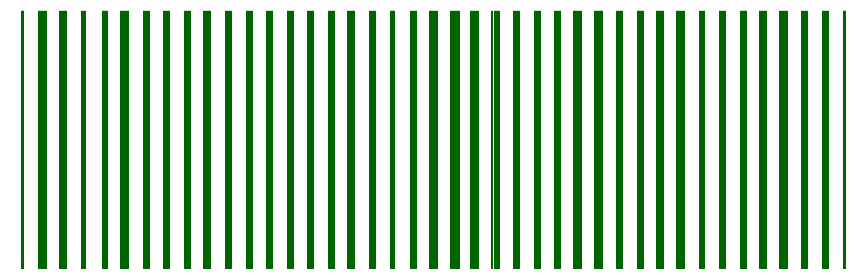

In [24]:
# Open ERA5 snowfall grid
ds = xr.open_dataset('era5_snowfall.nc')

# Load snowfall and time for lat, lon from ERA5 monthly snowfall
snowfall = ds.sel(latitude=lat.value, longitude=lon_conv(lon.value)).sf.values # monthly snowfall in m water equivalent
time = np.array([float(str(t)[:4]) + (float(str(t)[5:7])-1.)/12. for t in ds.time.values])

# Plot the barsnowed
barsnowed(snowfall, time, 1e-32)